In [1]:
!!pip install -q MOABB

['\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/140.8 KB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╸\x1b\x1b━━\x1b \x1b133.1/140.8 KB\x1b \x1b5.5 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b140.8/140.8 KB\x1b \x1b3.6 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25h\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/243.5 KB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b243.5/243.5 KB\x1b \x1b8.2 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25h\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/630.1 KB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b630.1/630.1 KB\x1b \x1b26.1 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25h\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/90.6 KB\x1b \x1b?\x1b eta \x1b-:--

In [2]:
!pip install pywd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pywd: filename=pywd-0.0.3-py3-none-any.whl size=2238 sha256=db583b8b98b2c96f51473e02cef828a6f6db81ed77c5e117e8cf4600516d6975
  Stored in directory: /root/.cache/pip/wheels/3f/c8/c6/8271b284aa73a38a0f90821ec93ff431bfe29d5ac8ebe5848c
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=f4e7b3e6799bf245e6fff9595da45892a4761dde1e60a87c8a9d6be39f14087c
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built pywd docopt


In [3]:
import numpy as np
import scipy.signal
import scipy.io as sio
import matplotlib
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import mne
from pywt import wavedec 
import seaborn as sns

import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import svm
import moabb
from moabb.datasets import EPFLP300, utils
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery
from moabb.pipelines.features import LogVariance
from mne.filter import construct_iir_filter
moabb.set_log_level("info")


import math
from sklearn.metrics import confusion_matrix
import os.path as osp

from mne import get_config

from moabb.utils import set_download_dir
from google.colab import drive
drive.mount("/content/gdrive")
original_path = get_config("MNE_DATA")
print(f"The download directory is currently {original_path}")
new_path = '/content/gdrive/MyDrive/MNE'
set_download_dir(new_path)

Mounted at /content/gdrive
The download directory is currently None


In [4]:
def plot_confusion_matrix(x,y,model):
  Y_pred = model.predict(x)
  Y_pred_classes = Y_pred.round()
  confusion_mtx = confusion_matrix(y, Y_pred_classes) 
  f,ax = plt.subplots(figsize=(8, 8))
  sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

In [5]:
def filterAndResampleData(data,seglen,lp=12,hp=1,sf=2048,resample=64):
  iir_params = dict(order=6, ftype='butter', output='sos')  
  iir_params = construct_iir_filter(iir_params, [hp,lp], None, sf, 'bandpass', return_copy=False)
  data.filter(method='iir',iir_params=iir_params,h_freq=hp,l_freq=lp)
  return data.resample(math.ceil(((sf*32)/seglen)))

In [6]:
def getData(subjectNumbers,dataset=EPFLP300()):
  return dataset.get_data(subjectNumbers)

In [7]:
def getSubjectData(subjectNumber,session_number,run_number):
  session = f'session_{session_number}'
  run = f'run_{run_number}'
  return getData([subjectNumber])[subjectNumber][session][run]

In [8]:
def getTargetData(df):
  Target = df[df['STI']==2].index.values
  val = np.full(len(Target),2)
  targetDF= pd.DataFrame(Target)
  targetDF["value"]=val
  return targetDF

In [9]:
def getNonTargetData(df):
  nonTarget = df[df['STI']==1].index.values
  value = np.full(len(nonTarget),1)
  nontargetDF= pd.DataFrame(nonTarget)
  nontargetDF["value"]=value
  return nontargetDF

In [10]:
def getTottalData(df):
  targetDF = getTargetData(df)
  nontargetDF = getNonTargetData(df)
  totaldf = nontargetDF.append(targetDF,ignore_index=True) 
  TargetNnonTarget = totaldf.sort_values(by=[0],ignore_index=True)
  return TargetNnonTarget

In [11]:
def scaleAndExtractFeatures(segment,runNum,segindx):
  scaler = MinMaxScaler(feature_range = (-1,1))
  df = segment.to_data_frame()
  columns = ['time', 'MA1', 'MA2' , 'STI']
  df.drop(columns,axis=1,inplace=True)
  semg= np.empty([2048,32])
  for val in df.columns.values:
    vals=df[val].values.reshape(-1, 1)
    scaled = scaler.fit_transform(vals)
    column= np.squeeze(scaled, axis=1)
    df[val]=column
  return np.expand_dims(df.to_numpy(), axis=2) 

In [12]:
def divideSingleRun(df, data,runNum):
  TargetNnonTarget= getTottalData(df)
  segments=[]
  output=[]
  length=len(TargetNnonTarget)
  for index, row in TargetNnonTarget.iterrows():
    if(index==length-1):
      Segment = df.iloc[TargetNnonTarget[0].iloc[index]:]
    else:
      Segment = df.iloc[TargetNnonTarget[0].iloc[index]:TargetNnonTarget[0].iloc[index]+2048]

    # crop segment from RawArray
    d = data.copy()
    Segment.reset_index(inplace=True)
    tmax= Segment['time'][len(Segment)-1]
    tmin= Segment['time'][0]
    seg=d.crop(tmin=tmin, tmax=tmax)

    # Filter and resample
    filtered = filterAndResampleData(seg,len(Segment))

    # Scale and extract features
    if(len(filtered.to_data_frame())!=32):
      continue
    featureVector= scaleAndExtractFeatures(filtered,runNum,index)

    segments.append(featureVector)
    output.append(TargetNnonTarget['value'].iloc[index])
  return segments, output

In [13]:
def prepareSubjectDataForSVM(subjectNumber):
  x_train=[]
  y_train=[]
  for sessionNumber in range(1,4):
    for runNumber in range(1,7):
      data=getSubjectData(subjectNumber,sessionNumber,runNumber)
      df=data.to_data_frame()
      segments, target = divideSingleRun(df, data, runNumber)
      x_train+=segments
      y_train+=target
    print("   session Number ",sessionNumber , " completed.......")
  x_test =[]
  y_test =[]
  for runNumber in range(1,7):
      data=getSubjectData(subjectNumber,4,runNumber)
      df=data.to_data_frame()
      segments, target = divideSingleRun(df, data,runNumber)
      x_test+=segments
      y_test+=target
  return x_train,y_train, x_test ,y_test

# **Convolutional Neural Networks for EEG**

EEG data is seen as a 2D-array, with the number of time steps as the width, and the number of electrodes as the height (as seen in Figure), EEG data has similar characteristics to an image or audio signal. 

![EEG](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*v13vF7Z79a869hafuVGJzg.png)

Data of nearby timepoints is important for the current datapoint, as well as data from the other channels at the same timepoint. Using convolutions and non-linearities, a CNN can learn local non-linear features and local patterns in these types of data.

Regarding CNNs for EEG data, the most popular models are developed with so-called **temporal and spatial convolutions**.

**A temporal convolution** has a kernel size of 1 x timepoints, where the sliding window will go over each channel with a certain timeframe, and therefore summarizes the EEG data over the timeframe for each channel.

**A spatial convolution** is applied over all channels, for each timepoint, and thus summarizes information over all channels. The convolutions can be applied multiple times with different kernel values, creating different types of summaries of the original data (called feature maps).

![temporal and spatial convolutions](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*9hBPUYQKpIbO0iihrKrxMg.png)

The goal of such convolutions was to represent the CSP pipeline by representing the frequency filtering with temporal convolutions, and spatial filtering with spatial convolutions.

Note:
*Overall, CSP pipelines can greatly enhance the signal-to-noise ratio of EEG signals, improve the accuracy of feature extraction, and facilitate the analysis of EEG data. This can lead to improved performance in various EEG-based applications, and ultimately, contribute to a better understanding of the brain and its functions.*

**Please note** that the original EEGNET differs a bit from our implementation explained here. For example, the authors of the original paper applied the model to **EEG data of 64 electrode channels x 128 timepoints**, while **we used EEG data of 32 electrode channels x 32 timepoints**. 

**In general**, we play around and experiment with the kernel sizes and parameter values when applying the network to our own data.

# **Implementation of EEGNet for 32-channel**

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.constraints import max_norm

def EEGNet(nb_classes, Chans=32, Samples=32):
    # Define the input shape
    input_shape = (Chans, Samples, 1)

    # Define the model architecture
    input_layer = layers.Input(shape=input_shape)

    block1 = layers.Conv2D(16, (1, 32), padding='same', input_shape=input_shape)(input_layer)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=2, depthwise_constraint=max_norm(1.))(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.SeparableConv2D(32, (1, 4), use_bias=False, padding='same')(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.MaxPooling2D((1, 4))(block1)
    block1 = layers.Dropout(0.25)(block1)

    block2 = layers.DepthwiseConv2D((1, 4), use_bias=False, depth_multiplier=2, depthwise_constraint=max_norm(1.))(block1)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.SeparableConv2D(64, (1, 4), use_bias=False, padding='same')(block2)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.MaxPooling2D((1, 2))(block2)
    block2 = layers.Dropout(0.25)(block2)

    flatten = layers.Flatten()(block2)

    dense = layers.Dense(256, activation='elu')(flatten)
    dense = layers.Dropout(0.5)(dense)

    output_layer = layers.Dense(1, activation='sigmoid')(dense)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

This implementation assumes that the EEG data is stored in a NumPy array with shape **(num_trials, num_channels, num_samples)**, and the labels are stored in a NumPy array with shape **(num_trials, num_classes)**

In [15]:
# data = np.expand_dims(data, axis=3)

# # Split the data into training and testing sets
# split = int(0.8 * len(data))
# x_train, y_train = data[:split], labels[:split]
# x_test, y_test = data[split:], labels[split:]
x_train,y_train, x_test ,y_test = prepareSubjectDataForSVM(1)
def mmap(x):
  return 0 if x==1  else 1
x_train = np.array(x_train).astype(np.float64)
y_train = np.array(y_train).astype(int)
x_test = np.array(x_test).astype(np.float64)
y_test = np.array(y_test).astype(int)
y_train = np.array([mmap(x) for x in y_train])
y_test = np.array([mmap(x) for x in y_test])

/usr/local/lib/python3.9/dist-packages/moabb/datasets/download.py:53: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_EPFLP300_PATH"
  set_config(key, get_config("MNE_DATA"))


unzip /content/gdrive/MyDrive/MNE/MNE-epflp300-data/groups/m/mm/mmspg/www/BCI/p300/subject1.zip
   session Number  1  completed.......
   session Number  2  completed.......
   session Number  3  completed.......


In [16]:
X= np.concatenate([x_train, x_test])
Y= np.concatenate([y_train, y_test])


In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
 X, Y, test_size=0.3, random_state=42)

Epoch 1/10
146/146 [==============================] - 5s 9ms/step - loss: 0.4962 - accuracy: 0.8032 - val_loss: 0.7217 - val_accuracy: 0.1670
Epoch 2/10
146/146 [==============================] - 1s 7ms/step - loss: 0.4380 - accuracy: 0.8208 - val_loss: 0.6937 - val_accuracy: 0.5020
Epoch 3/10
146/146 [==============================] - 1s 9ms/step - loss: 0.3964 - accuracy: 0.8405 - val_loss: 0.5064 - val_accuracy: 0.7500
Epoch 4/10
146/146 [==============================] - 1s 10ms/step - loss: 0.3916 - accuracy: 0.8401 - val_loss: 0.4168 - val_accuracy: 0.8130
Epoch 5/10
146/146 [==============================] - 2s 10ms/step - loss: 0.3489 - accuracy: 0.8602 - val_loss: 0.3908 - val_accuracy: 0.8340
Epoch 6/10
146/146 [==============================] - 1s 8ms/step - loss: 0.3619 - accuracy: 0.8611 - val_loss: 0.3984 - val_accuracy: 0.8310
Epoch 7/10
146/146 [==============================] - 1s 8ms/step - loss: 0.3397 - accuracy: 0.8636 - val_loss: 0.3979 - val_accuracy: 0.8340
Epoc

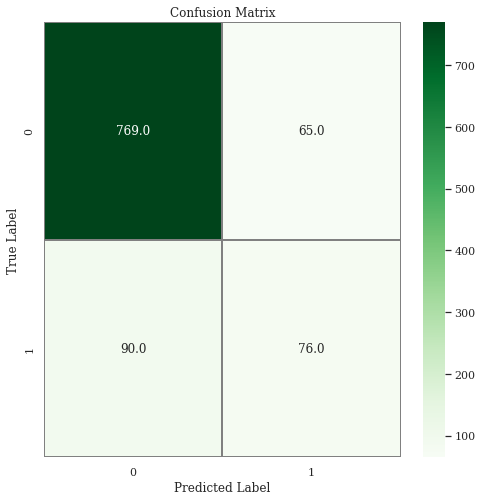

In [91]:

eegmodel = EEGNet(nb_classes=2)
eeghistory = eegmodel.fit(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_test, y_test))
plot_confusion_matrix(x_test,y_test,eegmodel)

73/73 [==============================] - 0s 3ms/step


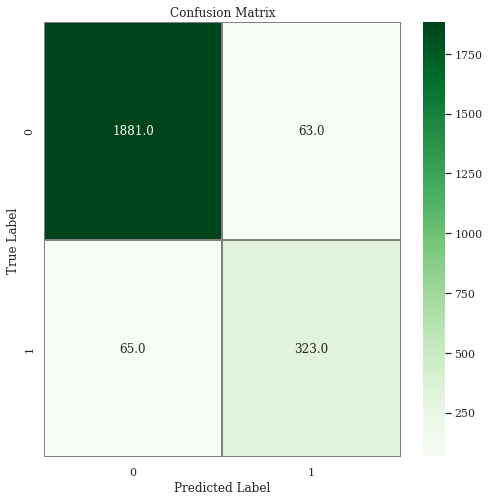

In [19]:
plot_confusion_matrix(x_train,y_train,eegmodel)

# Visualize the architecture of the EEGNet network in the form of an image

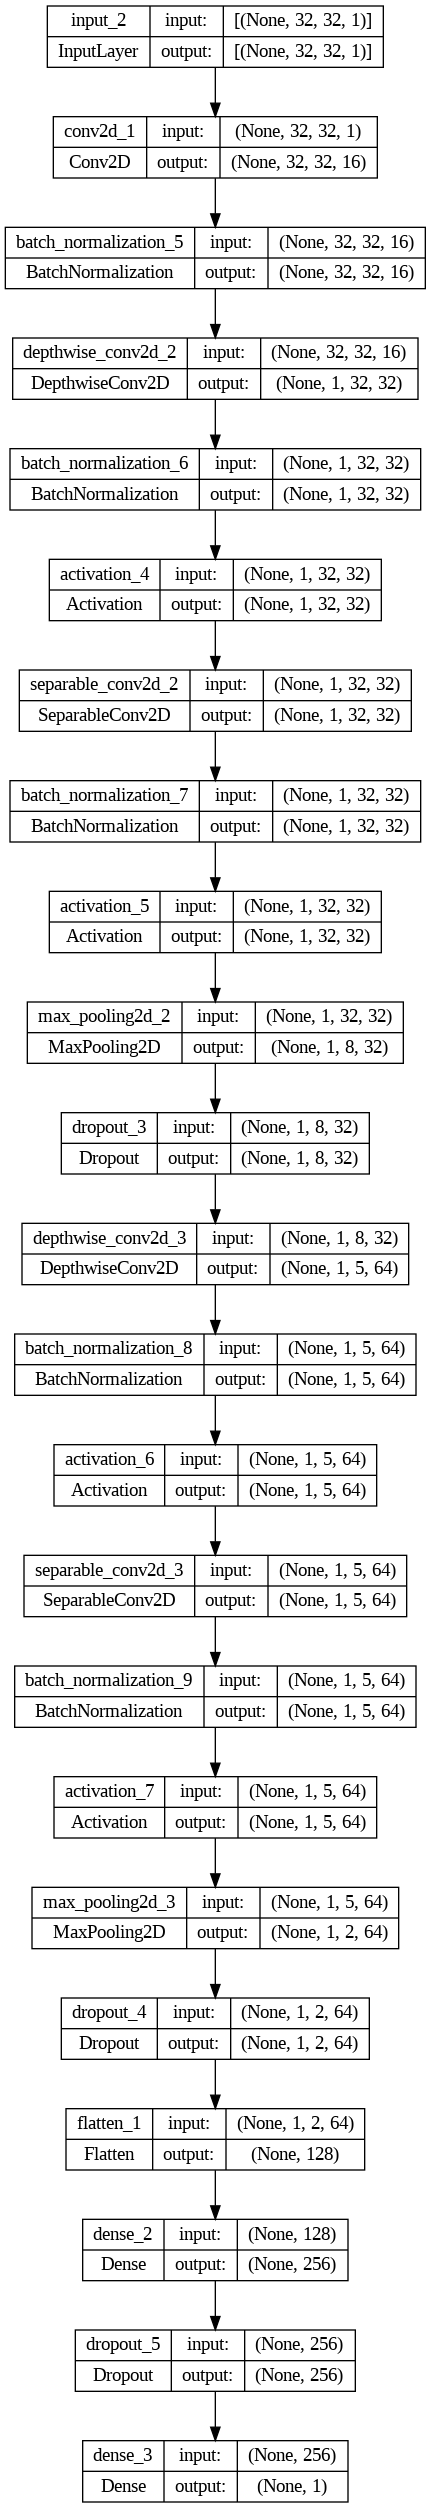

In [20]:
from tensorflow.keras.utils import plot_model
model = EEGNet(nb_classes=1)
plot_model(model, to_file='eegnet_binary.png', show_shapes=True, show_layer_names=True)

In [21]:

import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GRU, Dense, Reshape
from tensorflow.keras.models import Model

In [83]:
def ChronoNet(input_shape=(32, 32, 1)):
  # Input layer
  X_input = Input(input_shape)

  # Convolutional layer
  X = Conv2D(8, (32, 1), strides=(4, 1), padding='same', activation=None)(X_input)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2, 1), strides=(2, 1), padding='same')(X)
  X = Dropout(0.5)(X)
  # Reshape output of Convolutional layer to (batch_size, timesteps, input_dim)
  X = Reshape((-1, X.shape[2] * X.shape[3]))(X)

  # Recurrent layer
  X = GRU(16, return_sequences=True)(X)
  X = Dropout(0.5)(X)
  X = GRU(16)(X)
  X = Dropout(0.5)(X)

  # Output layer
  X = Dense(1, activation='sigmoid')(X)

  # Create model
  model = Model(inputs=X_input, outputs=X)

  return model
      

In [84]:
model = ChronoNet(input_shape=(32, 32, 1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],run_eagerly=True)

In [85]:
# Assuming X_train and y_train are the training data
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/50
37/37 [==============================] - 5s 87ms/step - loss: 0.5215 - accuracy: 0.7989 - val_loss: 0.4502 - val_accuracy: 0.8340
Epoch 2/50
37/37 [==============================] - 2s 56ms/step - loss: 0.4874 - accuracy: 0.8315 - val_loss: 0.4485 - val_accuracy: 0.8340
Epoch 3/50
37/37 [==============================] - 2s 55ms/step - loss: 0.4819 - accuracy: 0.8302 - val_loss: 0.4481 - val_accuracy: 0.8340
Epoch 4/50
37/37 [==============================] - 2s 56ms/step - loss: 0.4654 - accuracy: 0.8332 - val_loss: 0.4460 - val_accuracy: 0.8340
Epoch 5/50
37/37 [==============================] - 2s 57ms/step - loss: 0.4640 - accuracy: 0.8336 - val_loss: 0.4436 - val_accuracy: 0.8340
Epoch 6/50
37/37 [==============================] - 2s 67ms/step - loss: 0.4657 - accuracy: 0.8332 - val_loss: 0.4454 - val_accuracy: 0.8340
Epoch 7/50
37/37 [==============================] - 3s 85ms/step - loss: 0.4665 - accuracy: 0.8302 - val_loss: 0.4411 - val_accuracy: 0.8340
Epoch 8/50
37

32/32 [==============================] - 1s 19ms/step


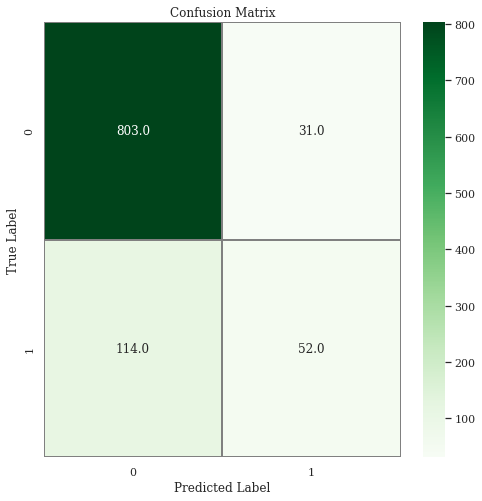

In [86]:
plot_confusion_matrix(x_test,y_test,model)

In [70]:
#Deep recurrent conv NN
def DRCNN(num_samples=64,num_channels=32,time_steps = 32):

    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(time_steps, num_channels)))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [47]:
def CNN(input_shape=(32, 32, 1)):
  # Define the CNN model
  model = tf.keras.Sequential()

  # Add the convolutional layers
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)))
  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))

  # Add the pooling layers
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  # Add the flatten layer
  model.add(layers.Flatten())

  # Add the fully connected layers
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


  return model

Epoch 1/50
73/73 [==============================] - 13s 41ms/step - loss: 0.4880 - accuracy: 0.8259 - val_loss: 0.4331 - val_accuracy: 0.8340
Epoch 2/50
73/73 [==============================] - 1s 16ms/step - loss: 0.3779 - accuracy: 0.8336 - val_loss: 0.3979 - val_accuracy: 0.8340
Epoch 3/50
73/73 [==============================] - 1s 16ms/step - loss: 0.3075 - accuracy: 0.8632 - val_loss: 0.4023 - val_accuracy: 0.8490
Epoch 4/50
73/73 [==============================] - 1s 16ms/step - loss: 0.2515 - accuracy: 0.9027 - val_loss: 0.4176 - val_accuracy: 0.8320
Epoch 5/50
73/73 [==============================] - 1s 16ms/step - loss: 0.2138 - accuracy: 0.9151 - val_loss: 0.5122 - val_accuracy: 0.8250
Epoch 6/50
73/73 [==============================] - 1s 16ms/step - loss: 0.1532 - accuracy: 0.9408 - val_loss: 0.5623 - val_accuracy: 0.8360
Epoch 7/50
73/73 [==============================] - 1s 16ms/step - loss: 0.1247 - accuracy: 0.9498 - val_loss: 0.7376 - val_accuracy: 0.8070
Epoch 8/50
7

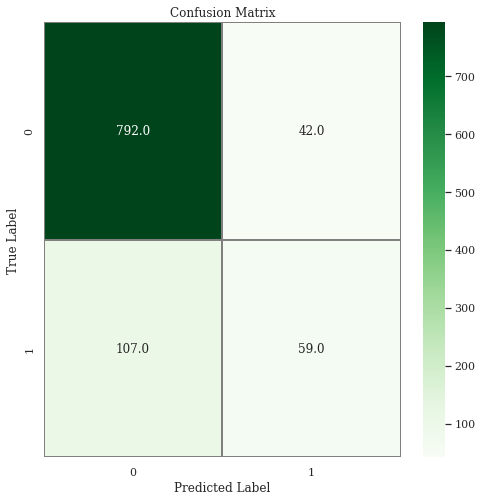

In [72]:
model = DRCNN(time_steps=32)
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))
plot_confusion_matrix(x_test,y_test,model)